In [ ]:
# %pip install pyramid

In [1]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
# from pyramid.ARIMA import auto_arima
import os.path
from os import path


# Khởi tạo Spark Session
spark = SparkSession.builder.appName("kafka").getOrCreate()
sc = spark.sparkContext
# Tạo DataFrame mẫu
train_data = spark.read.csv("../data/train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("../data/test_data.csv", inferSchema=True, header=True)


In [2]:
training_set = train_data.select("close").toPandas().values
# Thuc hien scale du lieu gia ve khoang 0,1
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

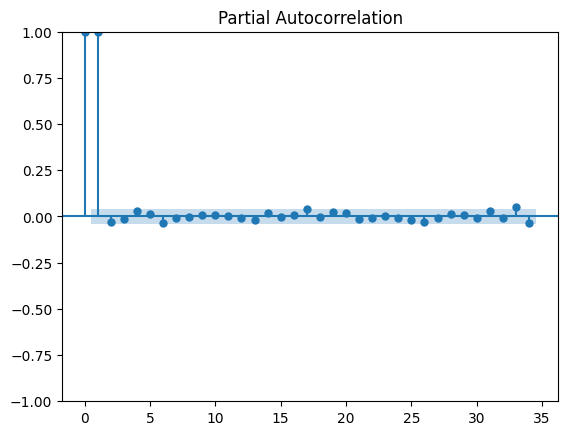

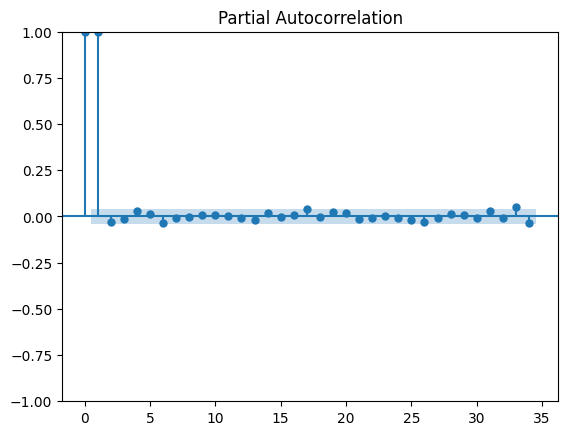

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_pacf(training_set)

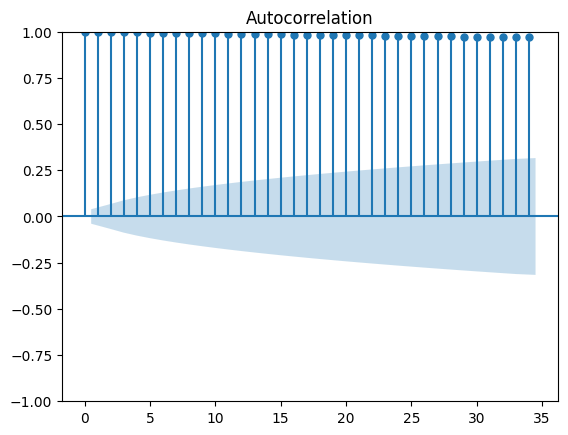

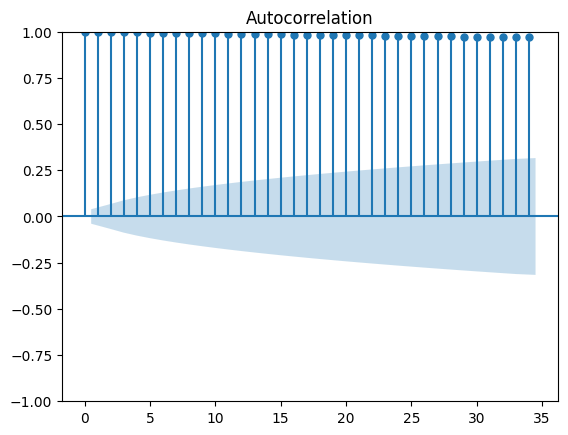

In [4]:
plot_acf(training_set)


In [23]:
# Xây dựng mô hình ARIMA
model = ARIMA(training_set, order=(60, 1, 30))  # Thay đổi order tùy thuộc vào dữ liệu
results = model.fit()

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Dự báo cho tương lai
forecast_steps = 249
forecast = results.forecast(steps=forecast_steps)
y_pre =forecast
y_pre = [[y] for y in y_pre]

In [25]:
forecast

array([53746.27494325, 53979.19916137, 54578.42400386, 54648.01560855,
       54819.19370648, 54293.11571625, 54665.69173101, 54396.31358969,
       54580.85653782, 54626.453184  , 54781.60893458, 54854.65722219,
       54761.81513684, 54483.95498517, 54920.90381381, 55007.41213128,
       55360.22648613, 55401.80919409, 55514.52742904, 55549.30583319,
       56327.82413578, 56603.80604312, 56601.25369811, 56512.17134243,
       56210.0156803 , 55589.9207473 , 55417.99139529, 55336.32070069,
       55147.19997669, 55166.45875779, 54669.04430063, 54788.53843675,
       55122.76393806, 54561.26262522, 54263.31858387, 54296.6134741 ,
       53544.44024952, 53583.40885189, 53796.19334141, 53779.6181356 ,
       53809.6661562 , 53643.55045852, 53713.59160611, 53845.56770903,
       53871.61830546, 54155.78995891, 54143.70746248, 54083.1590545 ,
       54350.76260912, 54559.02655306, 54902.90436765, 55055.64581232,
       55081.04585356, 55222.24394567, 55098.98112788, 55168.96589079,
      

In [26]:
test_set = test_data.select("close").toPandas().values

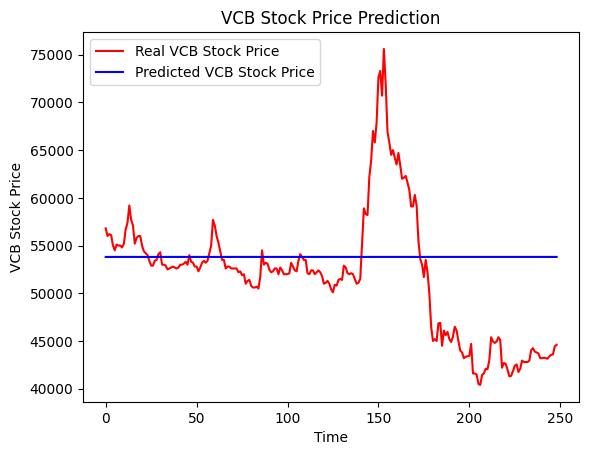

In [11]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(test_set, color = 'red', label = 'Real VCB Stock Price')
plt.plot(y_pre, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
# plt.savefig('svm_result.jpg')
plt.show()

In [5]:
# Tìm kiếm tối ưu cho các tham số p, d, q
model = pm.auto_arima(training_set, start_p=1, start_q=1, max_p=5, max_q=5, m=1,
                      start_P=0, seasonal=False, d=1, D=1, trace=True,
                      error_action='ignore', suppress_warnings=True, stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42487.298, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42487.838, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42485.599, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42485.763, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42486.212, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42486.788, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42488.254, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42483.936, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42485.109, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=42485.614, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42484.101, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=42486.561, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.454 seconds


In [7]:
test_set = test_data.select("close").toPandas().values

In [8]:
forecast = model.predict(n_periods=len(test_set))
y_pre = forecast
y_pre = [[y] for y in y_pre]

In [9]:
y_pre


[[53808.16350108286],
 [53808.49671483251],
 [53808.51031578654],
 [53808.51087094355],
 [53808.51089360368],
 [53808.510894528605],
 [53808.51089456636],
 [53808.5108945679],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51089456797],
 [53808.51

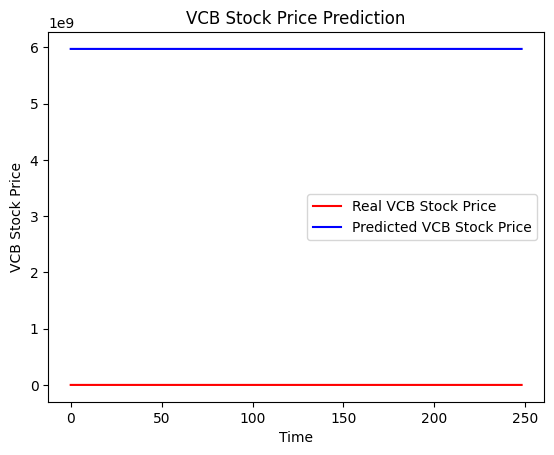

In [10]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(test_set, color = 'red', label = 'Real VCB Stock Price')
plt.plot(scaler.inverse_transform(np.array(y_pre)), color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
# plt.savefig('svm_result.jpg')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=411.148, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=408.766, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=409.840, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=409.727, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=408.011, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.198 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -203.005
Date:                Mon, 22 Jan 2024   AIC                            408.011
Time:                        23:21:58   BIC                            411.015
Sample:                             0   HQIC                           409.231
                                - 150                                         
Co

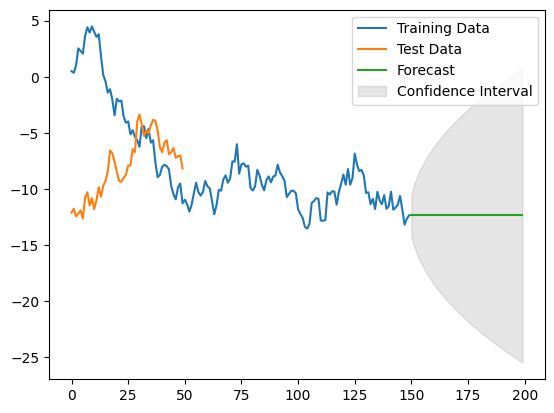

In [19]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Tạo dữ liệu giả định
np.random.seed(42)
data = np.cumsum(np.random.randn(200))

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train, test = train_test_split(data, train_size=150)

# Tìm kiếm tối ưu cho các tham số p, d, q
model = pm.auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                      start_P=0, seasonal=False, d=None, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True, stepwise=True)

# In thông tin về mô hình tối ưu
print(model.summary())

# Dự báo cho tập kiểm tra
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Trực quan hóa kết quả
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(np.arange(len(train), len(train) + len(test)), forecast, label='Forecast')
plt.fill_between(np.arange(len(train), len(train) + len(test)), conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()
